<a href="https://colab.research.google.com/github/daeunni/Statistical_DL/blob/main/lec_code/11_%EB%A8%B8%EC%8B%A0%EB%B2%88%EC%97%AD_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Translation
- 영어와 프랑스어 번역하기

In [1]:
import pandas as pd
import numpy as np
import string

In [3]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
lines= pd.read_table('/content/drive/MyDrive/Colab Notebooks/DL/[STAT433] 딥러닝을 위한 통계적모델링/data/english to french.txt', names=['eng', 'fr'])

In [ ]:
lines.head(3)

In [ ]:
lines = lines[0:50000]

# 1. Preprocessing 

In [ ]:
 # 소문자로 만들기 
lines['eng']=lines['eng'].apply(lambda x: x.lower()) 
lines['fr']=lines['fr'].apply(lambda x: x.lower())

In [ ]:
# 문장부호 없애기
exclude = set(string.punctuation)
lines.eng=lines.eng.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))  
lines.fr=lines.fr.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

In [ ]:
lines.head(3)

In [ ]:
# start와 end를 추가한다!
lines.fr = lines.fr.apply(lambda x : 'start '+ x + ' end')

In [ ]:
lines.head(3)   

In [ ]:
lines.shape

## 토큰화

In [ ]:
# fit a tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [ ]:
## 영어
import json
eng_tokenizer = create_tokenizer(lines['eng'])
eng_dict=json.loads(json.dumps(eng_tokenizer.word_counts))  

df =pd.DataFrame([eng_dict.keys(), eng_dict.values()]).T
df.columns = ['word','count']
df = df.sort_values(by='count',ascending = False)

df['cum_count']=df['count'].cumsum()  # 단어 등장 빈도
df['cum_perc'] = df['cum_count']/df['cum_count'].max()  # 단어 등장 비율
final_eng_words = df[df['cum_perc']<0.8]['word'].values   # 상위 80퍼센트 등장한 단어만 사용

In [ ]:
final_eng_words   # 80% 빈도수를 차지하는 총 영어 단어의 수 

In [ ]:
df.head()

In [ ]:
## 프랑스어
fr_tokenizer = create_tokenizer(lines['fr'])
fr_dict = json.loads(json.dumps(fr_tokenizer.word_counts))

df =pd.DataFrame([fr_dict.keys(), fr_dict.values()]).T
df.columns = ['word','count']
df = df.sort_values(by='count',ascending = False)

df['cum_count']=df['count'].cumsum()   # 단어 등장 빈도
df['cum_perc'] = df['cum_count']/df['cum_count'].max()  # 단어 등장 비율
final_fr_words = df[df['cum_perc']<0.8]['word'].values

In [ ]:
final_fr_words    # 80% 빈도수를 차지하는 총 프랑스 단어의 수 

In [ ]:
df.head()

In [ ]:
 # 영어, 프랑스어에서 80%차지하는 unique한 단어 개수
print('80% 차지하는 unique한 영어 단어 개수 : ', len(final_eng_words))
print('80% 차지하는 unique한 프랑스 단어 개수 : ', len(final_fr_words)) 

### 80%에 해당하지 않는 단어는 unknown으로 하나의 단어 클래스로 한다. 

따라서 머신 번역 문제는 385개의 영어 단어를 입력해 358개의 프랑스 단어를 구분하는 문제이다!       
(class가 358개인 다중분류문제, categorical crossentropy)

In [ ]:
# 위 80%에 해당하지 않는 단어는 unknown으로 전환한다!
def filter_eng_words(x):
  t = []
  x = x.split()
  for i in range(len(x)):
    if x[i] in final_eng_words:
      t.append(x[i])
    else:
      t.append('unk')  # unknown 
  x3 = ''
  for i in range(len(t)):
    x3 = x3+t[i]+' '   # 공백을 준다
  return x3

# 프랑스어 함수
def filter_fr_words(x):
  t = []
  x = x.split()
  for i in range(len(x)):
    if x[i] in final_fr_words:
      t.append(x[i])
    else:
      t.append('unk')
  x3 = ''
  for i in range(len(t)):
    x3 = x3+t[i]+' '   # 공백을 준다
  return x3

In [ ]:
filter_eng_words('he is extremely good')   # extremely > unk 변환! 

In [ ]:
# unk설정 + 마지막 공백
lines['eng']=lines['eng'].apply(filter_eng_words)
lines['fr']=lines['fr'].apply(filter_fr_words)

In [ ]:
lines.head()

In [ ]:
# 유일한 영어와 프랑스어 집합
all_eng_words=set()
for eng in lines.eng:
    for word in eng.split():
        if word not in all_eng_words:
            all_eng_words.add(word)
    
all_french_words=set()
for fr in lines.fr:
    for word in fr.split():
        if word not in all_french_words:
            all_french_words.add(word)

In [ ]:
# 유일한 영어, 프랑스어 집합
input_words = sorted(list(all_eng_words))
target_words = sorted(list(all_french_words))
num_encoder_tokens = len(all_eng_words)
num_decoder_tokens = len(all_french_words)

In [ ]:
print(input_words[10:20])  # 영어
print(target_words[10:20])  # 프랑스어

print(num_encoder_tokens, num_decoder_tokens)

In [ ]:
set(all_french_words) - set(final_fr_words)   # unknown 포함 여부 차이

In [ ]:
print('unknown 포함 유일한 영어 집합 원소 개수 : ', len(input_words))
print('unknown 포함 유일한 프랑스어 집합 원소 개수 : ', len(target_words))

In [ ]:
# 인덱스와 단어를 딕셔너리로 매핑
input_token_index = dict(
    [(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict(
    [(word, i+1) for i, word in enumerate(target_words)])

In [ ]:
input_token_index

In [ ]:
print(input_token_index['unk'])
print(target_token_index['start'])
print(target_token_index['end'])
print(list(input_token_index.keys())[335])   # unknown은 336번으로 매핑

In [ ]:
# RNN 시간스텝 정의를 위한 가장 긴 문장 찾기

length_list=[]   # 영어
for l in lines.eng:
    length_list.append(len(l.split(' ')))
eng_max_length = np.max(length_list)

length_list=[]   # 프랑스어
for l in lines.fr:
    length_list.append(len(l.split(' ')))
fr_max_length = np.max(length_list)

In [ ]:
print(eng_max_length)   # 영어는 8개의 단어가 가장 긴 문장
print(fr_max_length)    # 프랑스어는 17개의 단어가 가장 긴 문장

In [ ]:
# Time step 기반 RNN Input data 생성(우선 zero로 shape만 맞춰서 생성함)
encoder_input_data = np.zeros(
    (len(lines['eng']), eng_max_length),
    dtype='float32')

decoder_input_data = np.zeros(
    (len(lines['fr']), fr_max_length),
    dtype='float32')

decoder_target_data = np.zeros(
    (len(lines['fr']), fr_max_length, num_decoder_tokens+1),
    dtype='float32')

In [ ]:
# 시간스텝(단어 수)와 5만개의 문장 수
print(encoder_input_data.shape)
print(decoder_input_data.shape)
print(decoder_target_data.shape)   # 디코더는 358 + 1로 지정(index=0은 그냥 빈 공간으로 정의)
# (표본, 시간스텝, 359개의 단어 원핫 벡터)

- Encoder_input_data : 영어 문장 저장
- Decoder_input_data : 영어 문장에 대응되는 프랑스어 문장
- Decoder_target_data : Decoder_input_data보다 한 시점 앞서게 해서 번역을 예측문제로 전환

> 현재 영어 단어와 프랑스어 단어로 다음에 오는 프랑스어 단어를 예측하는 문제가 된다. 

In [ ]:
encoder_input_data[3]

In [ ]:
# 데이터 직접 생성
for i, (input_text, target_text) in enumerate(zip(lines['eng'], lines['fr'])):

    for t, word in enumerate(input_text.split()):
        encoder_input_data[i, t] = input_token_index[word]

    for t, word in enumerate(target_text.split()):
        decoder_input_data[i, t] = target_token_index[word]

        if t>0:
            decoder_target_data[i, t - 1, target_token_index[word]] = 1.

            if t== len(target_text.split())-1:
                decoder_target_data[i, t:, 89] = 1   # 0은 모두 89로 대체함 

In [ ]:
print(decoder_input_data.shape, encoder_input_data.shape, decoder_target_data.shape)

In [ ]:
decoder_input_data   # 0은 모두 end를 의미하는 89로 채움! 

In [ ]:
encoder_input_data

In [ ]:
for i in range(decoder_input_data.shape[0]):
    for j in range(decoder_input_data.shape[1]):
        if(decoder_input_data[i][j]==0):
            decoder_input_data[i][j] = 89

# 2. Attention
- encoder output과 decoder 출력값의 유사성인 attention을 계산해 인코더에 가중치를 부여한다. 

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import dot
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Dropout, Activation, concatenate


################################ 인코더 #################################
encoder_inputs = Input(shape=(eng_max_length,))
en_x=  Embedding(num_encoder_tokens+1, 128)(encoder_inputs)
en_x = Dropout(0.1)(en_x)   # dropout 추가
encoder_outputs, state_h, state_c = LSTM(256, return_sequences=True, return_state=True)(en_x)
encoder_states=[state_h, state_c]   

################################ 디코더 #################################
decoder_inputs = Input(shape=(fr_max_length,))
dex=  Embedding(num_decoder_tokens+1,128)(decoder_inputs)
decoder = Dropout(0.1)(dex)
decoder = LSTM(256, return_sequences=True)(decoder, initial_state=encoder_states)   # 인코더 state와 연결!!

print('decoder', decoder)

In [ ]:
t = Dense(5000, activation='tanh')(encoder_outputs)
t1 = Dense(5000, activation='tanh')(decoder)
print(t)
print(t1)

KerasTensor(type_spec=TensorSpec(shape=(None, 8, 5000), dtype=tf.float32, name=None), name='dense_3/Tanh:0', description="created by layer 'dense_3'")
KerasTensor(type_spec=TensorSpec(shape=(None, 17, 5000), dtype=tf.float32, name=None), name='dense_4/Tanh:0', description="created by layer 'dense_4'")


In [ ]:
# attention 가중치 계산 
attention = dot([t1, t], axes=[2, 2])
attention

<KerasTensor: shape=(None, 17, 8) dtype=float32 (created by layer 'dot')>

In [ ]:
attention = Dense(eng_max_length, activation='tanh')(attention)
attention = Activation('softmax')(attention)
context = dot([attention, encoder_outputs], axes = [2,1])
print('attention', attention)
print('context', context)

attention KerasTensor(type_spec=TensorSpec(shape=(None, 17, 8), dtype=tf.float32, name=None), name='activation/truediv:0', description="created by layer 'activation'")
context KerasTensor(type_spec=TensorSpec(shape=(None, 17, 256), dtype=tf.float32, name=None), name='dot_1/MatMul:0', description="created by layer 'dot_1'")


In [ ]:
decoder_combined_context = concatenate([context, decoder])
print('decoder_combined_context', decoder_combined_context)

decoder_combined_context KerasTensor(type_spec=TensorSpec(shape=(None, 17, 512), dtype=tf.float32, name=None), name='concatenate/concat:0', description="created by layer 'concatenate'")


In [ ]:
decoder_combined_context = Dense(2000, activation='tanh')(decoder_combined_context)
output = Dense( num_decoder_tokens+1, activation="softmax")(decoder_combined_context)
print('output', output)

output KerasTensor(type_spec=TensorSpec(shape=(None, 17, 359), dtype=tf.float32, name=None), name='dense_7/truediv:0', description="created by layer 'dense_7'")


In [ ]:
model3 = Model(inputs=[encoder_inputs, decoder_inputs], outputs=[output])
model3.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])

In [ ]:
model3.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 17)]         0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 8, 128)       49408       input_6[0][0]                    
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 17, 128)      45952       input_7[0][0]                    
____________________________________________________________________________________________

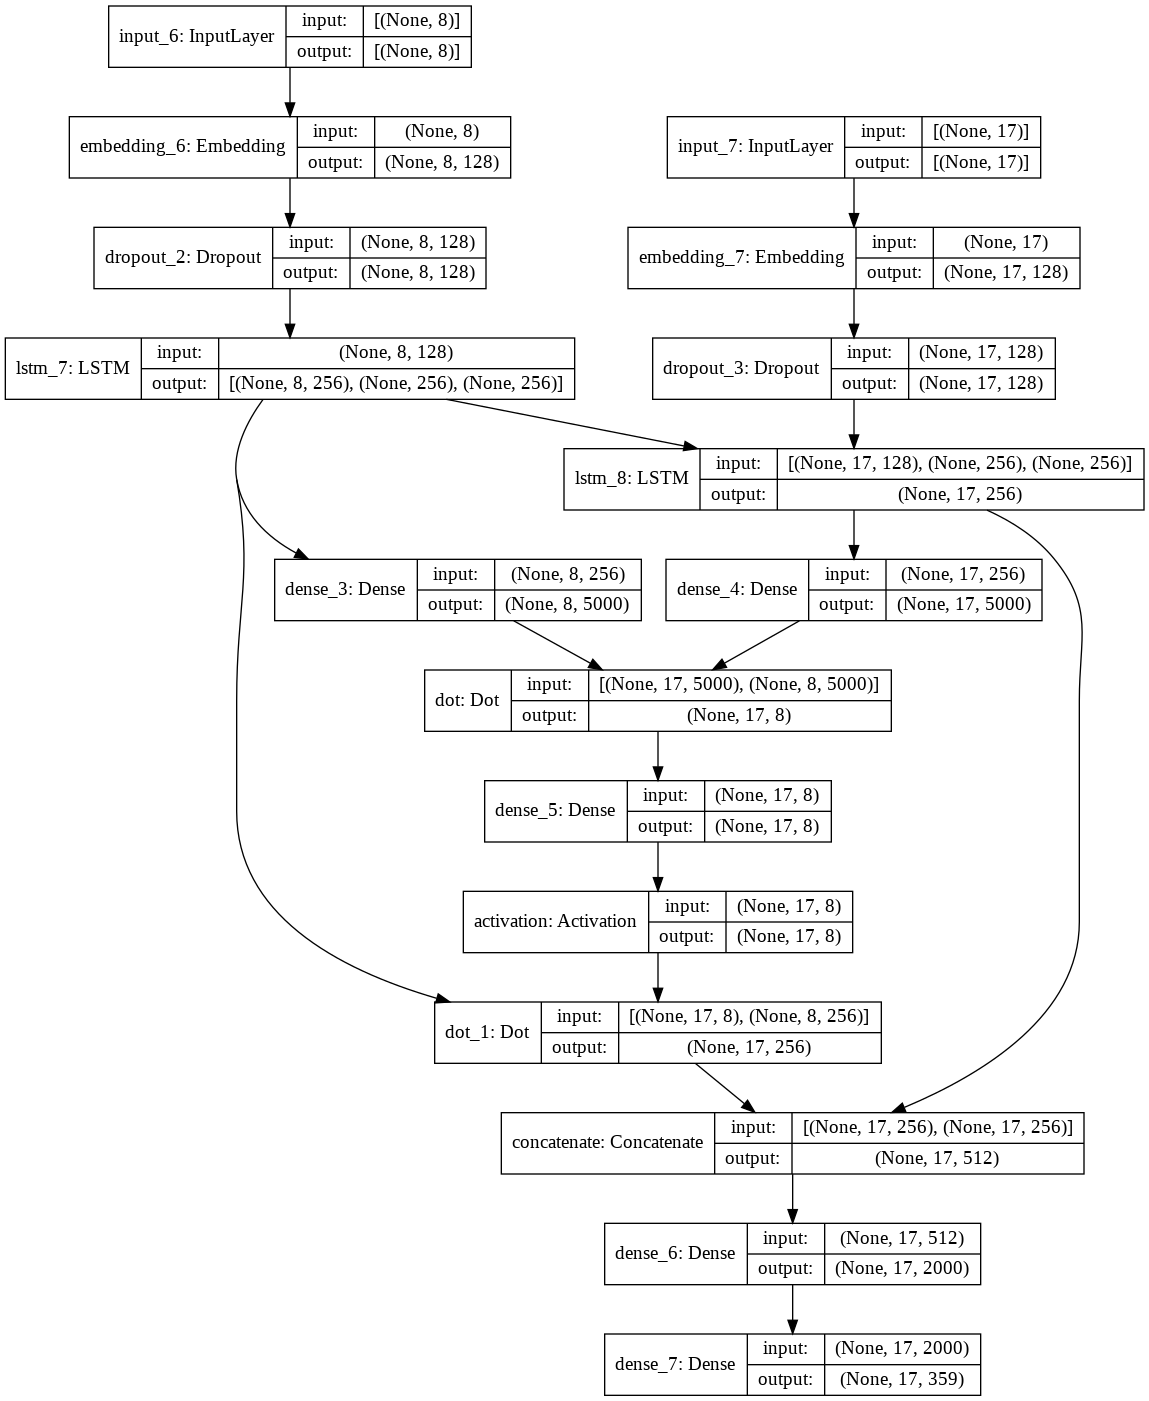

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model3, show_shapes=True, show_layer_names=True, to_file='model.png')
from IPython.display import Image
Image(retina=True, filename='model.png')

In [ ]:
history3 = model3.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=32,
          epochs=5,
          validation_split=0.05)

Epoch 1/5
1485/1485 [==============================] - 22s 12ms/step - loss: 0.9881 - accuracy: 0.8228 - val_loss: 0.6929 - val_accuracy: 0.8338
Epoch 2/5
1485/1485 [==============================] - 17s 12ms/step - loss: 0.4507 - accuracy: 0.8873 - val_loss: 0.5919 - val_accuracy: 0.8488
Epoch 3/5
1485/1485 [==============================] - 17s 11ms/step - loss: 0.3815 - accuracy: 0.8995 - val_loss: 0.5452 - val_accuracy: 0.8599
Epoch 4/5
1485/1485 [==============================] - 17s 11ms/step - loss: 0.3349 - accuracy: 0.9086 - val_loss: 0.5219 - val_accuracy: 0.8653
Epoch 5/5
1485/1485 [==============================] - 17s 11ms/step - loss: 0.3183 - accuracy: 0.9115 - val_loss: 0.5107 - val_accuracy: 0.8679


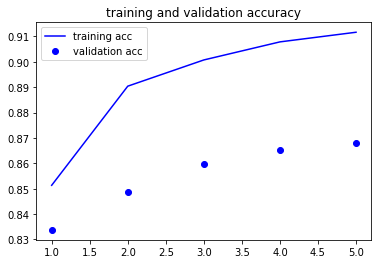

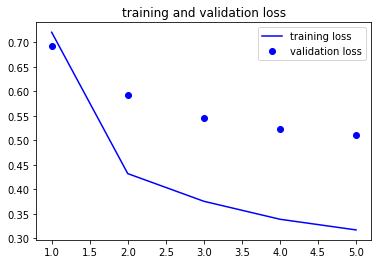

In [ ]:
import matplotlib.pyplot as plt
acc=history3.history['accuracy']
val_acc=history3.history['val_accuracy']
loss=history3.history['loss']
val_loss=history3.history['val_loss']
epochs=range(1,len(acc)+1)
plt.plot(epochs,acc,'b',label='training acc')
plt.plot(epochs,val_acc,'bo',label='validation acc')
plt.title('training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,loss,'b',label='training loss')
plt.plot(epochs,val_loss,'bo',label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

In [ ]:
decoder_input_data_pred = np.zeros(
    (len(lines.fr), fr_max_length),
    dtype='float32')

final_pred_att = []
for i in range(2500):
  word = 284
  for j in range(17):
    decoder_input_data_pred[(47500+i), j] = word
    pred = model3.predict([encoder_input_data[(47500+i)].reshape(1,8),decoder_input_data_pred[47500+i].reshape(1,17)])
    t = np.argmax(pred[0][j])
    word = t
    if word==89:
      break
  final_pred_att.append(list(decoder_input_data_pred[47500+i]))

In [ ]:
final_pred2_att = np.array(final_pred_att)
count = 0
correct_count = 0

for i in range(2500):
  correct_count += np.sum((decoder_input_data[47500+i]==final_pred2_att[i]) & (decoder_input_data[47500+i]!=89))
  count += np.sum(decoder_input_data[47500+i]!=89)
correct_count/count  

In [ ]:
k = -2400
t = model3.predict([encoder_input_data[k].reshape(1,encoder_input_data.shape[1]),decoder_input_data[k].reshape(1,decoder_input_data.shape[1])]).reshape(decoder_input_data.shape[1], num_decoder_tokens+1)

for i in range(len(encoder_input_data[k])):
  if int(encoder_input_data[k][i])!=0:
    print(list(input_token_index.keys())[int(encoder_input_data[k][i]-1)])

In [ ]:
t2 = np.argmax(t,axis=1)
for i in range(len(t2)):
  if int(t2[i])!=0:
    print(list(target_token_index.keys())[int(t2[i]-1)])

In [ ]:
t2 = decoder_input_data[k]
for i in range(len(t2)):
  if int(t2[i])!=0:
    print(list(target_token_index.keys())[int(t2[i]-1)])